# VVV Machine Analysis Samples size 2.5k

In [1]:
% matplotlib inline

import time
import pandas as pd

import numpy as np

from IPython import display as d

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, real_vs_predicted,
    discretize_classes, clean_features, union)

## 1. Load Data

In [2]:
start = time.time()

path = "/home/data/carpyncho/stored/samples/2.5K_VSTo0/"
data = container.read(path)

print("Removing b220...")
del data["b220"]

Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b263_sample2.5K_VSTo0.npy'...
Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b264_sample2.5K_VSTo0.npy'...
Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b278_sample2.5K_VSTo0.npy'...
Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b220_sample2.5K_VSTo0.npy'...
Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b261_sample2.5K_VSTo0.npy'...
Loading '/home/data/carpyncho/stored/samples/2.5K_VSTo0/b262_sample2.5K_VSTo0.npy'...
Removing b220...


##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
data, classes, sclasses = discretize_classes(data)
orig_cls_names = {v:k for k, v in classes.items()}
orig_scls_names = {v:k for k, v in sclasses.items()}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features(data, "b278")
print("Total features:", X_columns.size)

('Total features:', 53)


### 2.3. Selected features

In [5]:
X_columns.values

array(['cnt', 'Amplitude', 'AndersonDarling', 'Autocor_length',
       'Beyond1Std', 'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmo

### 2.4. Distribution

In [6]:
from collections import Counter
for n, df in data.items():
    d.display(d.Markdown("**Tile: {}**".format(n)))
    for k, v in Counter(df.scls).items():
        print "Class {}: {}".format(k, v)

**Tile: b262**

Class 0: 2491
Class 2: 5
Class 3: 298
Class 4: 3


**Tile: b263**

Class 0: 2490
Class 2: 6
Class 3: 307
Class 4: 5


**Tile: b261**

Class 0: 2472
Class 2: 24
Class 3: 220
Class 4: 6


**Tile: b278**

Class 0: 2478
Class 1: 2
Class 2: 13
Class 3: 424
Class 4: 7


**Tile: b264**

Class 0: 2494
Class 2: 2
Class 3: 299
Class 4: 3


### 2.5. Group Classes

In [7]:
preserve = [k for k in classes.keys() if k.startswith("RRLyr")]
data, classes = union(data, "cls", classes, preserve, 0)
data, sclasses = union(data, "scls", sclasses, "RRLyr", 0)

d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

**Classes**

{'': 0,
 'Cep-1': 0,
 'Cep-F': 0,
 'LPV-Mira': 0,
 'LPV-OSARG': 0,
 'LPV-SRV': 0,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 0,
 'T2Cep-RVTau': 0,
 'T2Cep-WVir': 0}

----

**Simplified Classes**

{'': 0, 'Cep': 0, 'LPV': 0, 'RRLyr': 3, 'T2Cep': 0}

### 2.6. Distribution Grouped

In [8]:
from collections import Counter
for n, df in data.items():
    d.display(d.Markdown("**Tile: {}**".format(n)))
    d.display(dict(Counter(df.scls)))

**Tile: b262**

{0: 2499, 3: 298}

**Tile: b263**

{0: 2501, 3: 307}

**Tile: b261**

{0: 2502, 3: 220}

**Tile: b278**

{0: 2500, 3: 424}

**Tile: b264**

{0: 2499, 3: 299}

In [9]:
%%html
<div style="background-color: #FFFF6F; color:#525200">
    <h2 style="padding: 10px; text-align:center">3. b278 Vs Itself (with 10 kfolds)</h2>
</div>

### 3.1. SVM - Linear

Execute a SVM with a linear kernel. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [10]:
svc_linear = KFoldExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses,
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time svc_linear = svc_linear("b278", nfolds=10)
real_vs_predicted(svc_linear, orig_cls_names)

             precision    recall  f1-score   support

        0.0       0.93      0.98      0.96      2500
        3.0       0.86      0.57      0.68       424

avg / total       0.92      0.92      0.92      2924

--------------------------------------------------------------------------------
CPU times: user 17 s, sys: 23.8 ms, total: 17 s
Wall time: 17.2 s


,Name,Total,Predicted0,Predicted3
0.0,Unknow,2478.0,0.986683,0.013317
1.0,Cep-1,2.0,1.000000,0.000000
2.0,Cep-F,13.0,0.923077,0.076923
3.0,LPV-Mira,424.0,0.429245,0.570755
4.0,LPV-OSARG,7.0,0.000000,1.000000


## 3.2. SVM - Polynomic

Execute a **SVM** with a **polynomic kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [11]:
svc_poly = KFoldExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time svc_poly= svc_poly("b278", nfolds=10)
real_vs_predicted(svc_poly, orig_cls_names)

             precision    recall  f1-score   support

        0.0       0.91      0.99      0.95      2500
        3.0       0.85      0.44      0.58       424

avg / total       0.90      0.91      0.89      2924

--------------------------------------------------------------------------------
CPU times: user 10 s, sys: 96 µs, total: 10 s
Wall time: 10.1 s


,Name,Total,Predicted0,Predicted3
0.0,Unknow,2478.0,0.989104,0.010896
1.0,Cep-1,2.0,1.000000,0.000000
2.0,Cep-F,13.0,0.923077,0.076923
3.0,LPV-Mira,424.0,0.558962,0.441038
4.0,LPV-OSARG,7.0,0.285714,0.714286


### 3.3. Random Forest

Execute a **Random Forest** with **500 c45** trees. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [12]:
rf = KFoldExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time rf = rf("b278", nfolds=10)
real_vs_predicted(rf, orig_cls_names)

             precision    recall  f1-score   support

        0.0       0.94      0.99      0.97      2500
        3.0       0.93      0.64      0.76       424

avg / total       0.94      0.94      0.94      2924

--------------------------------------------------------------------------------
CPU times: user 1min 29s, sys: 84 ms, total: 1min 29s
Wall time: 1min 29s


,Name,Total,Predicted0,Predicted3
0.0,Unknow,2478.0,0.993947,0.006053
1.0,Cep-1,2.0,1.000000,0.000000
2.0,Cep-F,13.0,1.000000,0.000000
3.0,LPV-Mira,424.0,0.363208,0.636792
4.0,LPV-OSARG,7.0,0.285714,0.714286


### 3.4. KNN

KNN with **3** neightbors ad weights determined by the **distance**. Docs: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [13]:
knn = KFoldExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time knn = knn("b278", nfolds=10)
real_vs_predicted(knn, orig_cls_names)

             precision    recall  f1-score   support

        0.0       0.92      0.99      0.95      2500
        3.0       0.88      0.47      0.61       424

avg / total       0.91      0.91      0.90      2924

--------------------------------------------------------------------------------
CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.9 s


,Name,Total,Predicted0,Predicted3
0.0,Unknow,2478.0,0.991525,0.008475
1.0,Cep-1,2.0,1.000000,0.000000
2.0,Cep-F,13.0,1.000000,0.000000
3.0,LPV-Mira,424.0,0.530660,0.469340
4.0,LPV-OSARG,7.0,0.285714,0.714286


### 3.5. Results

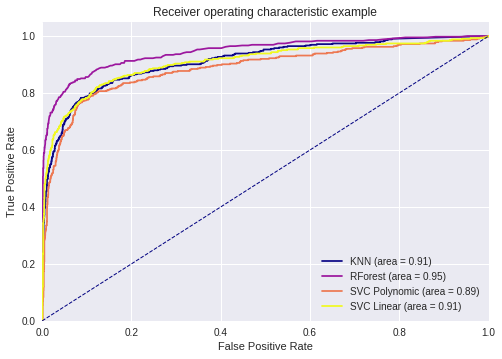

In [14]:
roc({"KNN": knn, "RForest": rf, 
     "SVC Linear": svc_linear,
     "SVC Polynomic": svc_poly})

----

In [15]:
%%html
<div style="background-color: #FFFF6F; color:#525200">
    <h2 style="padding: 10px; text-align:center">4. b261 Vs. All </h2>
</div>

### 4.1. SVM - Linear

b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2499
          3       0.94      0.62      0.75       298

avg / total       0.95      0.96      0.95      2797

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2501
          3       0.91      0.61      0.73       307

avg / total       0.95      0.95      0.95      2808

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b278 (TEST)
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      2500
          3       0.90      0.49      0.63       424

avg / total       0.92      0.92      0.91      2924

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b264 (TE

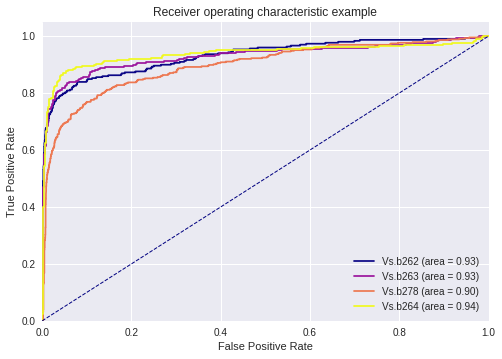

CPU times: user 183 ms, sys: 104 ms, total: 287 ms
Wall time: 181 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9953.0,0.993972,0.006028
1,Cep-1,2.0,1.000000,0.000000
2,Cep-F,26.0,0.961538,0.038462
3,LPV-Mira,1328.0,0.423193,0.576807
4,LPV-OSARG,18.0,0.388889,0.611111


In [16]:
svc_linear = WithAnotherExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_linear = svc_linear("b261")
%time roc(svc_linear)
real_vs_predicted(svc_linear, orig_cls_names)

### 4.2. SVM - Polynomic

b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      2499
          3       0.97      0.47      0.63       298

avg / total       0.94      0.94      0.93      2797

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2501
          3       0.91      0.47      0.62       307

avg / total       0.94      0.94      0.93      2808

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b278 (TEST)
             precision    recall  f1-score   support

          0       0.89      1.00      0.94      2500
          3       0.92      0.31      0.46       424

avg / total       0.90      0.90      0.87      2924

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b264 (TE

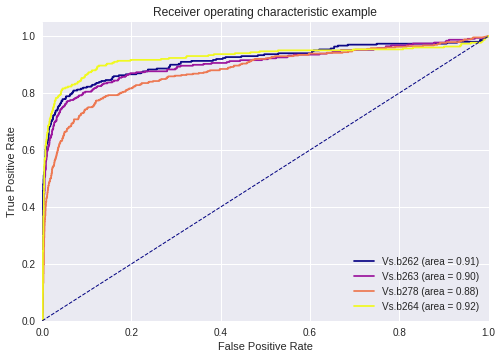

CPU times: user 186 ms, sys: 104 ms, total: 290 ms
Wall time: 181 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9953.0,0.996383,0.003617
1,Cep-1,2.0,1.000000,0.000000
2,Cep-F,26.0,1.000000,0.000000
3,LPV-Mira,1328.0,0.575301,0.424699
4,LPV-OSARG,18.0,0.666667,0.333333


In [17]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_poly = svc_poly("b261")
%time roc(svc_poly)
real_vs_predicted(svc_poly, orig_cls_names)

### 4.3. Random Forest

b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      2499
          3       0.99      0.48      0.65       298

avg / total       0.95      0.94      0.94      2797

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2501
          3       0.97      0.56      0.71       307

avg / total       0.95      0.95      0.94      2808

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b278 (TEST)
             precision    recall  f1-score   support

          0       0.91      1.00      0.95      2500
          3       0.98      0.44      0.61       424

avg / total       0.92      0.92      0.90      2924

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b264 (TE

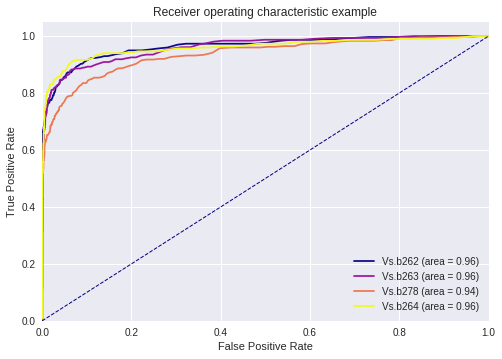

CPU times: user 217 ms, sys: 51.9 ms, total: 269 ms
Wall time: 261 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9953.0,0.999096,0.000904
1,Cep-1,2.0,1.000000,0.000000
2,Cep-F,26.0,1.000000,0.000000
3,LPV-Mira,1328.0,0.485693,0.514307
4,LPV-OSARG,18.0,0.666667,0.333333


In [18]:
rf = WithAnotherExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
rf = rf("b261")
%time roc(rf)
real_vs_predicted(rf, orig_cls_names)

### 4.4. KNN

b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2499
          3       0.91      0.50      0.64       298

avg / total       0.94      0.94      0.93      2797

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      2501
          3       0.89      0.47      0.61       307

avg / total       0.93      0.94      0.93      2808

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b278 (TEST)
             precision    recall  f1-score   support

          0       0.90      1.00      0.95      2500
          3       0.93      0.38      0.54       424

avg / total       0.91      0.91      0.89      2924

--------------------------------------------------------------------------------
b261 (TRAIN) Vs. b264 (TE

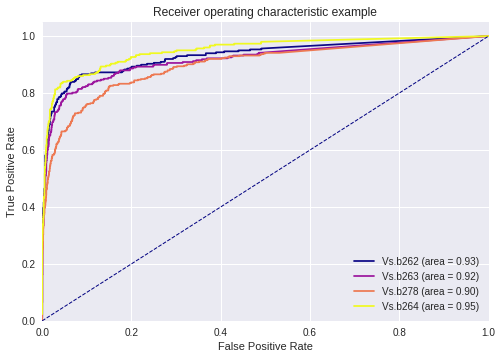

CPU times: user 187 ms, sys: 99.9 ms, total: 287 ms
Wall time: 179 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9953.0,0.995177,0.004823
1,Cep-1,2.0,1.000000,0.000000
2,Cep-F,26.0,1.000000,0.000000
3,LPV-Mira,1328.0,0.543675,0.456325
4,LPV-OSARG,18.0,0.333333,0.666667


In [19]:
knn = WithAnotherExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
knn = knn("b261")
%time roc(knn)
real_vs_predicted(knn, orig_cls_names)

In [20]:
%%html
<div style="background-color: #FFFF6F; color:#525200">
    <h2 style="padding: 10px; text-align:center">5. b278 Vs. All </h2>
</div>

### 5.1. SVM - Linear

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2499
          3       0.88      0.70      0.78       298

avg / total       0.96      0.96      0.96      2797

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2501
          3       0.89      0.71      0.79       307

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2502
          3       0.78      0.77      0.77       220

avg / total       0.96      0.96      0.96      2722

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

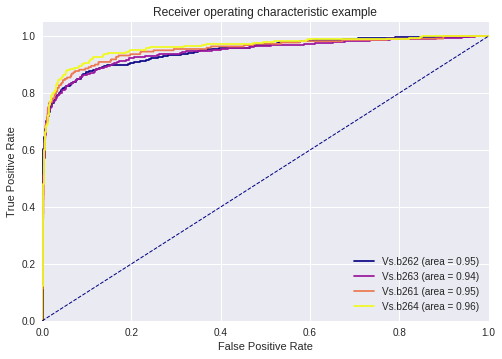

CPU times: user 165 ms, sys: 112 ms, total: 277 ms
Wall time: 178 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9947.0,0.986931,0.013069
2,Cep-F,37.0,1.000000,0.000000
3,LPV-Mira,1124.0,0.274911,0.725089
4,LPV-OSARG,17.0,0.294118,0.705882


In [21]:
svc_linear = WithAnotherExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_linear = svc_linear("b278")
%time roc(svc_linear)
real_vs_predicted(svc_linear, orig_cls_names)

### 5.2. SVM - Polynomic

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2499
          3       0.85      0.58      0.69       298

avg / total       0.94      0.94      0.94      2797

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      2501
          3       0.79      0.52      0.63       307

avg / total       0.93      0.93      0.93      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2502
          3       0.81      0.64      0.71       220

avg / total       0.96      0.96      0.96      2722

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

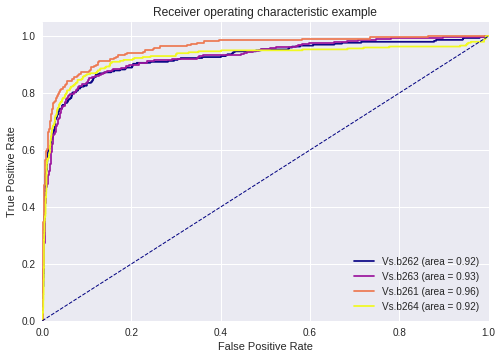

CPU times: user 184 ms, sys: 87.9 ms, total: 272 ms
Wall time: 185 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9947.0,0.987031,0.012969
2,Cep-F,37.0,0.945946,0.054054
3,LPV-Mira,1124.0,0.421708,0.578292
4,LPV-OSARG,17.0,0.235294,0.764706


In [22]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_poly = svc_poly("b278")
%time roc(svc_poly)
real_vs_predicted(svc_poly, orig_cls_names)

### 5.3. Random Forest

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2499
          3       0.96      0.65      0.78       298

avg / total       0.96      0.96      0.96      2797

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2501
          3       0.89      0.74      0.81       307

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2502
          3       0.89      0.80      0.84       220

avg / total       0.97      0.98      0.97      2722

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

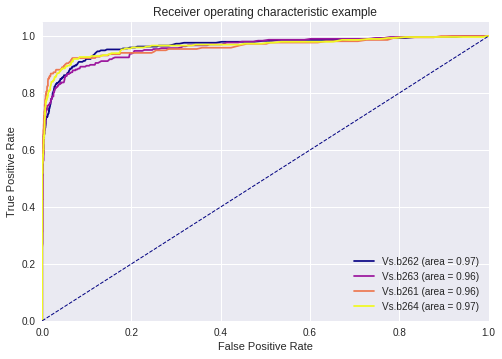

CPU times: user 223 ms, sys: 104 ms, total: 327 ms
Wall time: 223 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9947.0,0.992561,0.007439
2,Cep-F,37.0,1.000000,0.000000
3,LPV-Mira,1124.0,0.264235,0.735765
4,LPV-OSARG,17.0,0.705882,0.294118


In [23]:
rf = WithAnotherExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
rf = rf("b278")
%time roc(rf)
real_vs_predicted(rf, orig_cls_names)

### 5.4. KNN

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2499
          3       0.87      0.61      0.72       298

avg / total       0.95      0.95      0.94      2797

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2501
          3       0.87      0.55      0.68       307

avg / total       0.94      0.94      0.94      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2502
          3       0.83      0.65      0.73       220

avg / total       0.96      0.96      0.96      2722

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

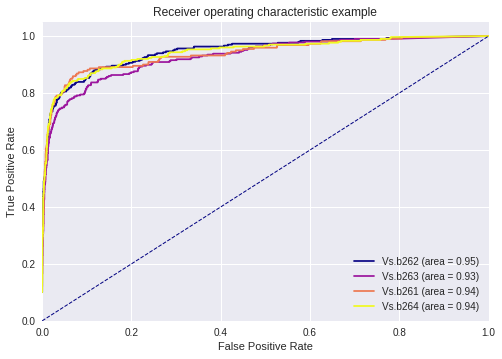

CPU times: user 181 ms, sys: 104 ms, total: 285 ms
Wall time: 177 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,9947.0,0.990449,0.009551
2,Cep-F,37.0,0.972973,0.027027
3,LPV-Mira,1124.0,0.399466,0.600534
4,LPV-OSARG,17.0,0.294118,0.705882


In [24]:
knn = WithAnotherExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
knn = knn("b278")
%time roc(knn)
real_vs_predicted(knn, orig_cls_names)

In [25]:
%%html
<div style="background-color: #FFFF6F; color:#525200">
    <h2 style="padding: 10px; text-align:center">6. b278+b261 Vs. All </h2>
</div>

### 6.1. SVM - Linear

b278 + b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2499
          3       0.94      0.66      0.77       298

avg / total       0.96      0.96      0.96      2797

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2501
          3       0.92      0.67      0.78       307

avg / total       0.96      0.96      0.95      2808

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b264 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2499
          3       0.90      0.71      0.79       299

avg / total       0.96      0.96      0.96      2798

--------------------------------------------------------------------------------


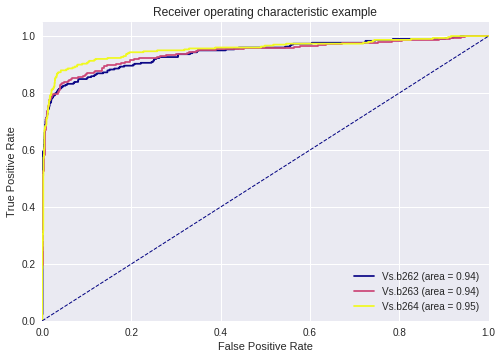

CPU times: user 196 ms, sys: 24.1 ms, total: 220 ms
Wall time: 176 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,7475.0,0.993579,0.006421
2,Cep-F,13.0,1.000000,0.000000
3,LPV-Mira,904.0,0.321903,0.678097
4,LPV-OSARG,11.0,0.363636,0.636364


In [26]:
svc_linear = WithAnotherExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_linear = svc_linear(["b278", "b261"])
%time roc(svc_linear)
real_vs_predicted(svc_linear, orig_cls_names)

### 6.2. SVM - Polynomic

b278 + b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2499
          3       0.90      0.59      0.71       298

avg / total       0.95      0.95      0.94      2797

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2501
          3       0.86      0.53      0.65       307

avg / total       0.94      0.94      0.93      2808

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b264 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2499
          3       0.89      0.59      0.71       299

avg / total       0.95      0.95      0.94      2798

--------------------------------------------------------------------------------


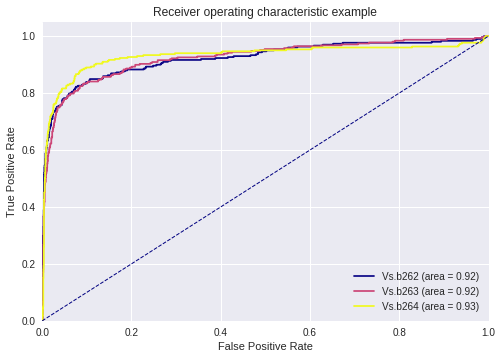

CPU times: user 192 ms, sys: 80 ms, total: 272 ms
Wall time: 170 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,7475.0,0.992107,0.007893
2,Cep-F,13.0,1.000000,0.000000
3,LPV-Mira,904.0,0.432522,0.567478
4,LPV-OSARG,11.0,0.272727,0.727273


In [27]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_poly = svc_poly(["b278", "b261"])
%time roc(svc_poly)
real_vs_predicted(svc_poly, orig_cls_names)

### 6.3. Random Forest

b278 + b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2499
          3       0.99      0.57      0.72       298

avg / total       0.96      0.95      0.95      2797

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2501
          3       0.95      0.68      0.80       307

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b264 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2499
          3       0.94      0.69      0.80       299

avg / total       0.96      0.96      0.96      2798

--------------------------------------------------------------------------------


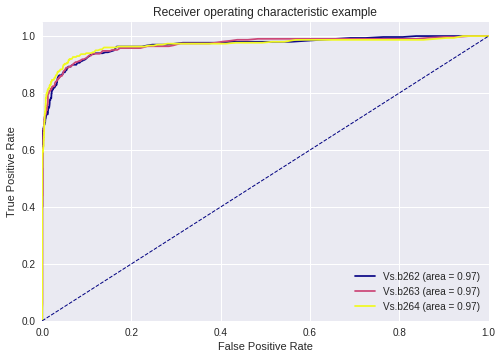

CPU times: user 168 ms, sys: 95.9 ms, total: 264 ms
Wall time: 169 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,7475.0,0.997324,0.002676
2,Cep-F,13.0,1.000000,0.000000
3,LPV-Mira,904.0,0.352876,0.647124
4,LPV-OSARG,11.0,0.727273,0.272727


In [28]:
rf = WithAnotherExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
rf = rf(["b278", "b261"])
%time roc(rf)
real_vs_predicted(rf, orig_cls_names)

### 6.4. KNN

b278 + b261 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2499
          3       0.88      0.61      0.72       298

avg / total       0.95      0.95      0.95      2797

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2501
          3       0.88      0.55      0.68       307

avg / total       0.94      0.94      0.94      2808

--------------------------------------------------------------------------------
b278 + b261 (TRAIN) Vs. b264 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2499
          3       0.90      0.60      0.72       299

avg / total       0.95      0.95      0.94      2798

--------------------------------------------------------------------------------


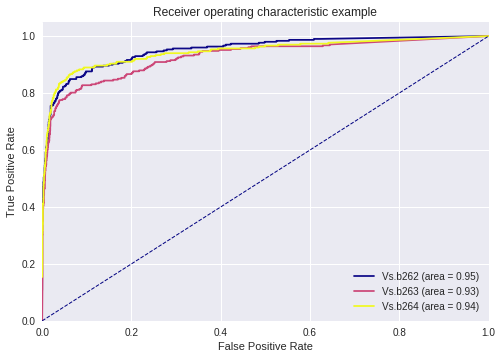

CPU times: user 176 ms, sys: 92 ms, total: 268 ms
Wall time: 169 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,7475.0,0.991839,0.008161
2,Cep-F,13.0,1.000000,0.000000
3,LPV-Mira,904.0,0.414823,0.585177
4,LPV-OSARG,11.0,0.454545,0.545455


In [29]:
knn = WithAnotherExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
knn = knn(["b278", "b261"])
%time roc(knn)
real_vs_predicted(knn, orig_cls_names)

In [30]:
%%html
<div style="background-color: #FFFF6F; color:#525200">
    <h2 style="padding: 10px; text-align:center">7. b278+b261+b264 Vs. All </h2>
</div>

### 7.1. SVM - Linear

b278 + b261 + b264 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2499
          3       0.93      0.67      0.78       298

avg / total       0.96      0.96      0.96      2797

--------------------------------------------------------------------------------
b278 + b261 + b264 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2501
          3       0.93      0.68      0.79       307

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------


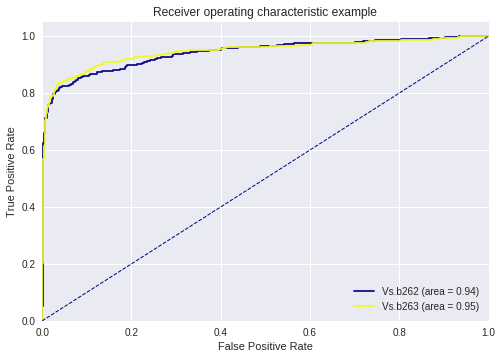

CPU times: user 167 ms, sys: 60 ms, total: 227 ms
Wall time: 166 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,4981.0,0.994981,0.005019
2,Cep-F,11.0,1.000000,0.000000
3,LPV-Mira,605.0,0.322314,0.677686
4,LPV-OSARG,8.0,0.375000,0.625000


In [31]:
svc_linear = WithAnotherExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_linear = svc_linear(["b278", "b261", "b264"])
%time roc(svc_linear)
real_vs_predicted(svc_linear, orig_cls_names)

### 7.2. SVM - Polynomic

b278 + b261 + b264 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2499
          3       0.90      0.61      0.72       298

avg / total       0.95      0.95      0.95      2797

--------------------------------------------------------------------------------
b278 + b261 + b264 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2501
          3       0.87      0.56      0.68       307

avg / total       0.94      0.94      0.94      2808

--------------------------------------------------------------------------------


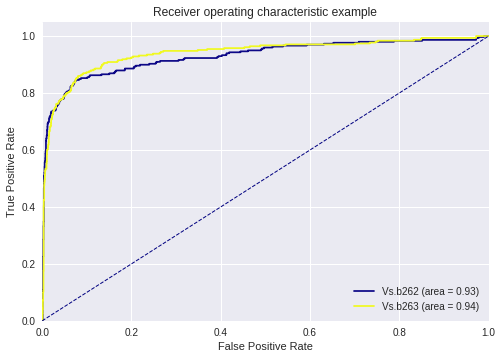

CPU times: user 170 ms, sys: 71.9 ms, total: 242 ms
Wall time: 166 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,4981.0,0.991769,0.008231
2,Cep-F,11.0,1.000000,0.000000
3,LPV-Mira,605.0,0.416529,0.583471
4,LPV-OSARG,8.0,0.250000,0.750000


In [32]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
svc_poly = svc_poly(["b278", "b261", "b264"])
%time roc(svc_poly)
real_vs_predicted(svc_poly, orig_cls_names)

### 7.3. Random Forest

b278 + b261 + b264 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2499
          3       0.99      0.62      0.77       298

avg / total       0.96      0.96      0.96      2797

--------------------------------------------------------------------------------
b278 + b261 + b264 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2501
          3       0.96      0.69      0.80       307

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------


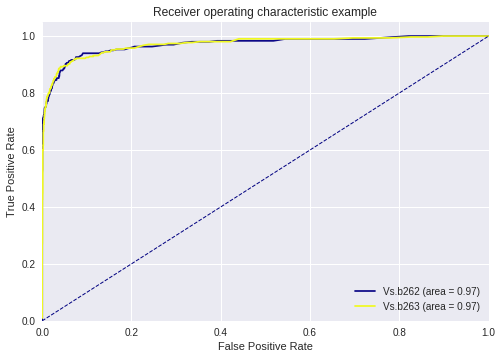

CPU times: user 219 ms, sys: 48 ms, total: 267 ms
Wall time: 274 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,4981.0,0.998193,0.001807
2,Cep-F,11.0,1.000000,0.000000
3,LPV-Mira,605.0,0.342149,0.657851
4,LPV-OSARG,8.0,0.875000,0.125000


In [33]:
rf = WithAnotherExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
rf = rf(["b278", "b261", "b264"])
%time roc(rf)
real_vs_predicted(rf, orig_cls_names)

### 7.4. KNN

b278 + b261 + b264 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2499
          3       0.88      0.62      0.73       298

avg / total       0.95      0.95      0.95      2797

--------------------------------------------------------------------------------
b278 + b261 + b264 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2501
          3       0.90      0.57      0.70       307

avg / total       0.94      0.95      0.94      2808

--------------------------------------------------------------------------------


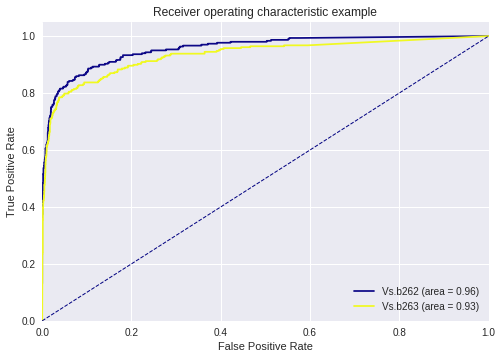

CPU times: user 156 ms, sys: 64 ms, total: 220 ms
Wall time: 165 ms


,Name,Total,Predicted0,Predicted3
0,Unknow,4981.0,0.991568,0.008432
2,Cep-F,11.0,1.000000,0.000000
3,LPV-Mira,605.0,0.404959,0.595041
4,LPV-OSARG,8.0,0.625000,0.375000


In [34]:
knn = WithAnotherExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), 
    clsnum=sclasses, data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
knn = knn(["b278", "b261", "b264"])
%time roc(knn)
real_vs_predicted(knn, orig_cls_names)

In [35]:
print("Total Run Time: " + str(time.time() - start))
del start

Total Run Time: 455.960808039
